## Modelo Futuros Mini Ibovespa - Dados Históricos


O Mercado Futuro é o ambiente onde você pode ganhar com a alta ou baixa de um determinado ativo, seja ele uma commodity (Milho, Café, Boi Gordo), uma moeda (como o dólar), um Índice (Bovespa, Índice S&P 500) ou mesmo uma taxa de juros. Nele, são negociados contratos futuros.

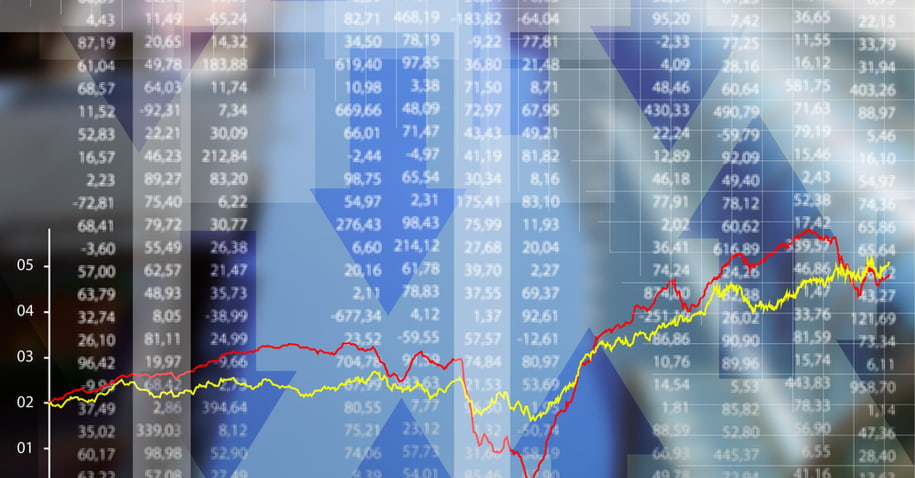

O mini índice é um contrato futuro derivado do Índice Bovespa, ou seja, é um ativo que tem como base o sobe e desce desse índice. Como esse tipo de operação envolve **risco considerável** e **oscilações frequentes no mercado**, ela é indicada apenas para aqueles que se encaixam no perfil de investidor arrojado.

Neste trabalho iremos implementar uma RNNs para realizar a predição diária do Mini Índice da Ibovespa.

O dataset **"BVSP.csv"** possui informações dispostas em colunas :

* **Date**:  Data das operações na bolsa (diária)
* **Close**:  Valor de Fechamento do Índice da Ibovespa (no dia)
* **Open**:  Valor da Abertura do Índice da Ibovespa (no dia)
* **High**:  Valor máximo do Índice da Ibovespa (no dia)
* **Low**:  Valor mínimo do Índice da Ibovespa (no dia)
* **Vol**:  Volume de contratos negociados (no dia)




### Bibliotecas

In [208]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import plotly.graph_objects as go 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Carregando os dados

Vamos começar lendo o arquivo FuturosMiniBovespa.csv em um dataframe do pandas, mas antes vamos dar uma olhadinha no gráfico de variação do último mês do índice Ibovespa.

In [209]:
DataSet=pd.read_csv('BVSP.csv')

In [210]:
fig = go.Figure(data=[go.Candlestick(x=DataSet['Date'],
                open=DataSet['Open'], high=DataSet['High'],
                low=DataSet['Low'], close=DataSet['Close'])
                     ])

fig.update_layout(xaxis_rangeslider_visible=False)  
fig.show()



## Rede Neural Recorrente (RNN)

Antes de avançar para LSTM, primeiro vamos introduzir o conceito de Redes Recorrentes. Elas são redes utilizadas para reconhecer padrões quando os resultados do passado influenciam no resultado atual. Um exemplo disso são as séries temporais, em que a ordem dos dados é muito importante. <br>

Nesta arquitetura, um neurônio tem como entrada seu estado anterior, além das entradas da camada anterior. A imagem abaixo ilustra esta nova modelagem.
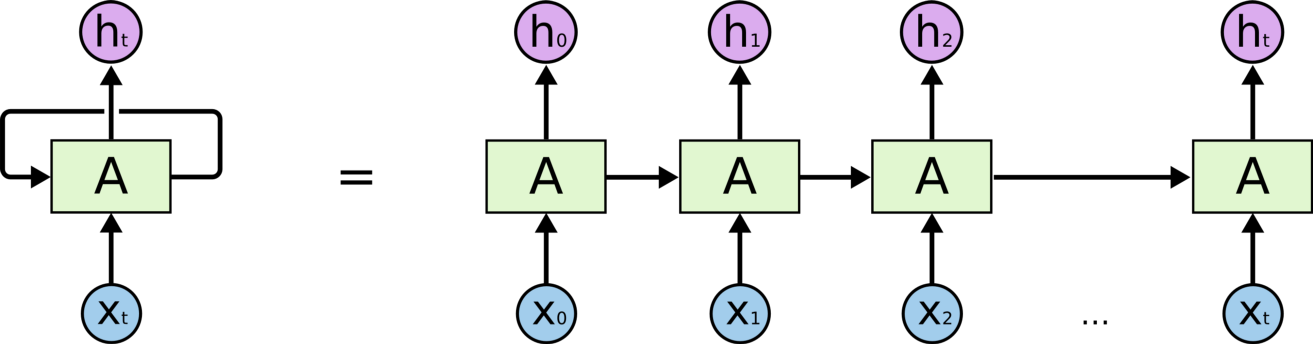


Observe que H representa o estado. Assim, no estado H_1, o neurônio recebe como parâmetro de entrada X_1 e, além disso, seu estado anterior H_0. O principal problema desta arquitetura é que os estados mais antigos são esquecidos muito rapidamente. Ou seja, para sequências em que precisamos lembrar além de um passado imediato, as redes RNNs são limitadas.


### Rede LSTM
Uma rede LSTM tem origem em uma RNN (Rede Neural Recorrente). Mas ela resolve o problema de memória mudando sua arquitetura.

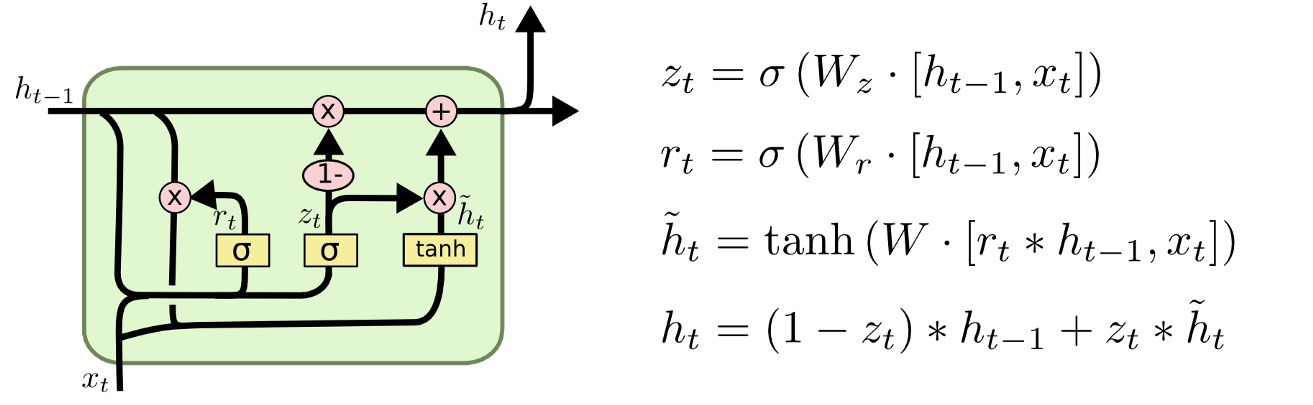

Nesta nova arquitetura, cada neurônio possui 3 gates, cada um com uma função diferente. São eles:
* Input Gate
* Output Gate
* Forget Gate

Agora, um neurônio LSTM recebe entradas de seu estado anterior, assim como ocorria na Rede Recorrente:
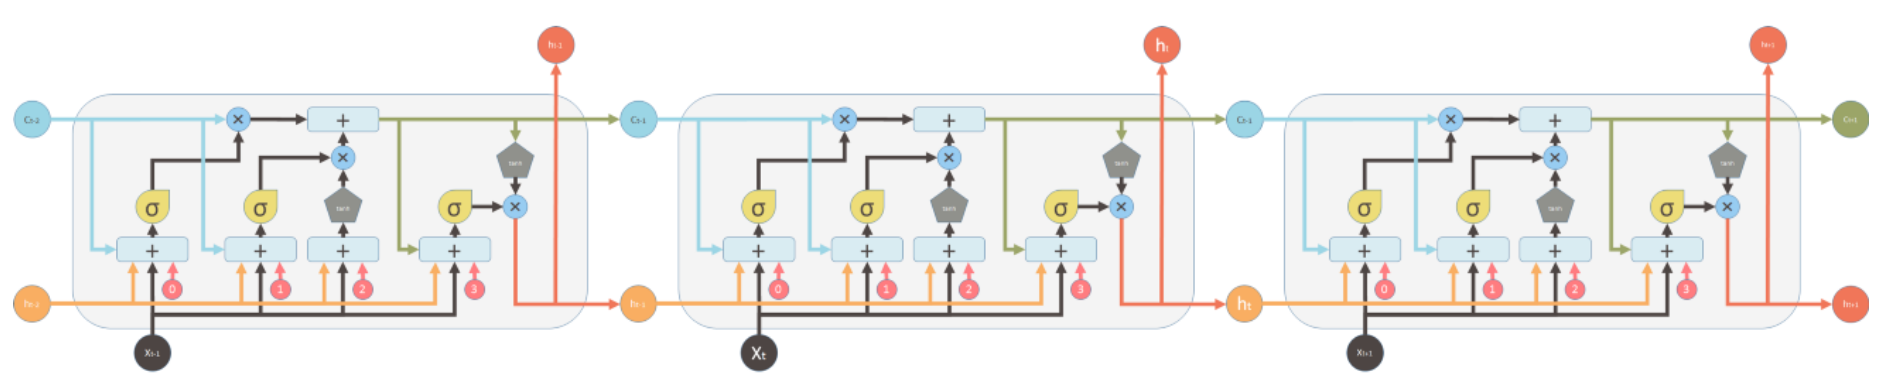

### Agora vamos ler o arquivo do período desejável 

In [211]:
DataSet=pd.read_csv('BVSP.csv')
DataSet=DataSet.dropna()
DataSet.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-05-16,51803.0,52305.0,51585.0,51803.0,51803.0,3529500
1,2016-05-17,51795.0,51946.0,50689.0,50839.0,50839.0,3871100
2,2016-05-18,50836.0,51373.0,50301.0,50562.0,50562.0,4072500
3,2016-05-19,50556.0,50556.0,49588.0,50133.0,50133.0,3905500
4,2016-05-20,50133.0,50822.0,49723.0,49723.0,49723.0,3254500


In [212]:
DataSet.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1.235000e+03
mean,85522.814575,86378.572470,84718.676923,85583.652632,85583.652632,5.357334e+06
std,19485.568423,19617.903994,19348.696298,19496.786975,19496.786975,3.113809e+06
min,48468.000000,49057.000000,48067.000000,48472.000000,48472.000000,0.000000e+00
25%,67957.500000,68658.000000,67284.500000,67976.500000,67976.500000,3.284300e+06
50%,84928.000000,85684.000000,84032.000000,84977.000000,84977.000000,4.189000e+06
75%,101082.000000,102080.500000,100061.500000,101168.000000,101168.000000,6.808250e+06
max,125075.000000,125324.000000,123227.000000,125077.000000,125077.000000,2.176870e+07


### Inicialmente iremos criar uma RNN baseada apenas no Valor de Abertura

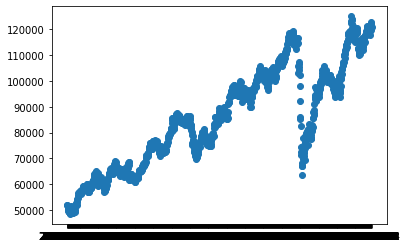

In [213]:
plt.scatter(DataSet['Date'],DataSet['Open'],)
plt.show()

base_treinamento = DataSet.iloc[:, 1:2].values

#DataSet.drop(['Date','Close','High','Low', 'Volume'],axis=1,inplace=True)

In [214]:
base_treinamento

array([[ 51803.],
       [ 51795.],
       [ 50836.],
       ...,
       [122964.],
       [119711.],
       [120719.]])

### Normalizar os dados do Mini Índice

In [215]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
DataScaled=scaler.fit_transform(base_treinamento)

In [216]:
print(DataScaled)

[[0.04353388]
 [0.04342945]
 [0.03091101]
 ...
 [0.97244377]
 [0.92998029]
 [0.94313836]]


### Definição dos previsores

In [217]:
previsores = []
preco_real = []
NRecursao = 90
DataSetLen = len(DataScaled)
print(DataSetLen)

1235


In [218]:

for i in range(NRecursao, DataSetLen):
    previsores.append(DataScaled[i-NRecursao:i,0])
    preco_real.append(DataScaled[i,0])

previsores, preco_real = np.array(previsores), np.array(preco_real)

In [219]:
previsores.shape

(1145, 90)

### Tranformar para o formato do Tensor do Keras

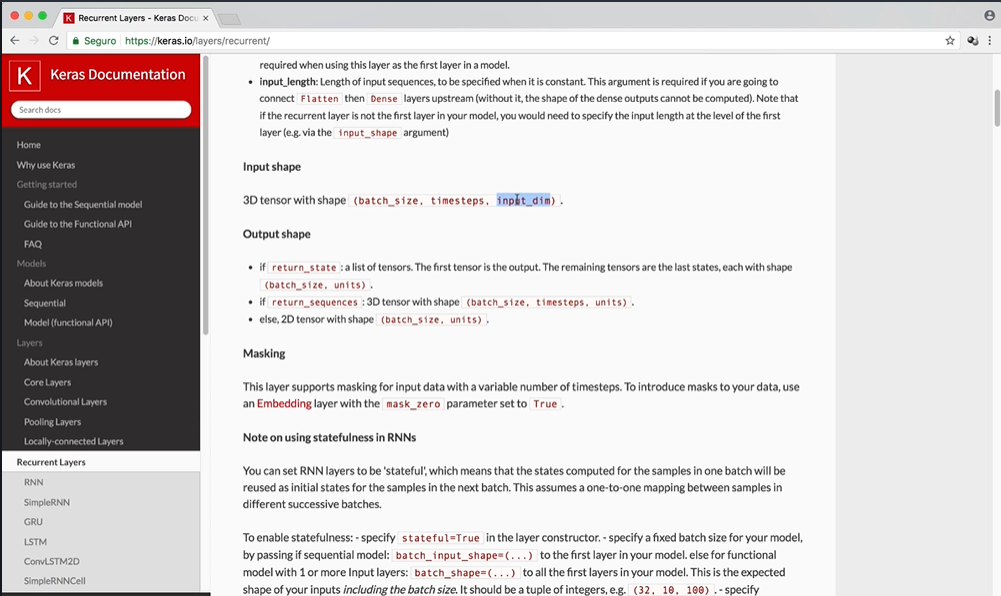

In [220]:
previsores = np.reshape(previsores, (previsores.shape[0], previsores.shape[1], 1))

In [221]:
previsores.shape

(1145, 90, 1)

### Estrutura da Rede Neural

In [222]:
# Camada de entrada
regressor = Sequential()
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (previsores.shape[1], 1)))
regressor.add(Dropout(0.3))

# Cada Oculta 1
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

# Cada Oculta 2
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

# Cada Oculta 3
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.3))

# Camada de Saída
regressor.add(Dense(units = 1, activation = 'linear'))


### Construindo a Rede

In [223]:
regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error',
                  metrics = ['mean_absolute_error'])
regressor.fit(previsores, preco_real, epochs = 20, batch_size = 32)

Epoch 1/20
36/36 [==============================] - 15s 200ms/step - loss: 0.0867 - mean_absolute_error: 0.2036
Epoch 2/20
36/36 [==============================] - 7s 199ms/step - loss: 0.0235 - mean_absolute_error: 0.1194
Epoch 3/20
36/36 [==============================] - 7s 204ms/step - loss: 0.0174 - mean_absolute_error: 0.1010
Epoch 4/20
36/36 [==============================] - 7s 197ms/step - loss: 0.0157 - mean_absolute_error: 0.0952
Epoch 5/20
36/36 [==============================] - 7s 201ms/step - loss: 0.0125 - mean_absolute_error: 0.0842
Epoch 6/20
36/36 [==============================] - 7s 201ms/step - loss: 0.0163 - mean_absolute_error: 0.0930
Epoch 7/20
36/36 [==============================] - 8s 211ms/step - loss: 0.0105 - mean_absolute_error: 0.0751
Epoch 8/20
36/36 [==============================] - 7s 196ms/step - loss: 0.0110 - mean_absolute_error: 0.0771
Epoch 9/20
36/36 [==============================] - 8s 211ms/step - loss: 0.0081 - mean_absolute_error: 0.0650


### Conjunto de dados para o Teste

In [224]:
DataSet_teste=pd.read_csv('BVSP.csv')

preco_real_teste = DataSet_teste.iloc[:, 1:2].values

base_completa = pd.concat((DataSet['Open'], DataSet_teste['Open']), axis = 0)
entradas = base_completa[len(base_completa) - len(DataSet_teste) - NRecursao:].values

entradas = entradas.reshape(-1, 1)
entradas = scaler.transform(entradas)

In [225]:
DataSetTestLen = len(DataSet_teste)
NPredictions = 90

X_teste = []
for i in range(NRecursao, DataSetTestLen+NRecursao):
    X_teste.append(entradas[i-NRecursao:i, 0])
    
X_teste = np.array(X_teste)
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))

previsoes = regressor.predict(X_teste)
previsoes = scaler.inverse_transform(previsoes)


In [226]:
RNN=[]
predictions_teste=X_teste[0].T
predictions_teste=np.reshape(predictions_teste, (predictions_teste.shape[0], predictions_teste.shape[1], 1))

predictions_teste[0][NRecursao-1][0]=regressor.predict(predictions_teste)[0][0]
RNN.append(regressor.predict(predictions_teste)[0])

for i in range(NPredictions-1):
    predictions_teste=np.roll(predictions_teste,-1)
    predictions_teste[0][NRecursao-1][0]=regressor.predict(predictions_teste)[0][0]
    RNN.append(regressor.predict(predictions_teste)[0])
RNN = scaler.inverse_transform(RNN)

print(RNN.mean())
print(previsoes.mean())
print(preco_real_teste.mean())

101244.89507566756
85178.71
85522.81457489879


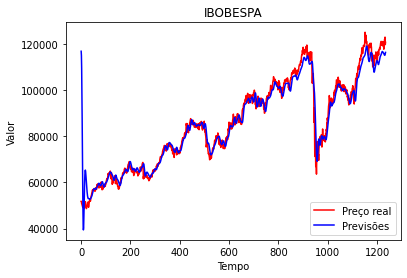

In [227]:
plt.plot(preco_real_teste, color = 'red', label = 'Preço real')
plt.plot(previsoes, color = 'blue', label = 'Previsões')
#plt.plot(RNN, color = 'green', label = 'RNN')

plt.title('IBOBESPA')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()
plt.show()

In [228]:
np.shape(previsoes)

(1235, 1)